In [1]:
import sys
import os
import h5py
import torch
import matplotlib.pyplot as plt
import numpy as np
import glob
import random
from typing import Union, Tuple, Optional
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from src.models.dqfno import DQFNO
from src.losses.data_losses import LpLoss, H1Loss
from src.training.adamw import AdamW

In [2]:
data_path = "/Users/anthonypoole/Data/TACC/hw2d_sim_step0.025_end1_pts512_c11_k015_N3_nu5e-8_20250205112740_25678_3.h5"
with h5py.File(data_path, 'r') as f:
    print(f['density'].shape)
    print(f.keys())

(8001, 64, 64)
<KeysViewHDF5 ['density', 'energy', 'enstrophy', 'enstrophy_phi', 'gamma_c', 'gamma_n', 'gamma_n_spectral', 'kinetic_energy', 'omega', 'phi', 'state_density', 'state_omega', 'state_phi', 'thermal_energy', 'time']>


In [3]:
def load_h5_pair(input_file: str, target_file: str, device: torch.device,
                 derived: bool = False) -> Union[Tuple[torch.Tensor, torch.Tensor],
                                                 Tuple[torch.Tensor, torch.Tensor, torch.Tensor]]:
    """
    Loads input and target data from HDF5 files.

    :param input_file: Path to the input file.
    :param target_file: Path to the target file.
    :param device: Torch device.
    :param derived: Whether to load the derived gamma_n quantity.
    :return: Tuple of (x, y) if not derived; otherwise (x, y, gamma_n).
    """
    def load_data(file: str) -> torch.Tensor:
        with h5py.File(file, 'r') as f:
            density = f['density'][:]
            omega = f['omega'][:]
            phi = f['phi'][:]
            # Stack along channel dimension and add a batch dimension.
            data = torch.tensor(np.stack((density, omega, phi), axis=1), dtype=torch.float32)
            # Rearranging dimensions as needed: (B, var_dim, T, H, W)
            return data.unsqueeze(0).permute(0, 2, 1, 3, 4)

    x = load_data(input_file)
    y = load_data(target_file)
    gamma_n: Optional[torch.Tensor] = None

    if derived:
        with h5py.File(target_file, 'r') as f:
            gamma_n = torch.tensor(f['gamma_n'][:], dtype=torch.float32)

    if derived:
        assert gamma_n is not None  # For type-checkers.
        return x.to(device), y.to(device), gamma_n.to(device)
    else:
        return x.to(device), y.to(device)
# Gather HDF5 file pairs.
input_pattern = "../src/data/input*.h5"
target_pattern = "../src/data/target*.h5"
input_files = sorted(glob.glob(input_pattern))
target_files = sorted(glob.glob(target_pattern))
paired_files = list(zip(input_files, target_files))
random.shuffle(paired_files)
split_idx = int(.8 * len(paired_files))
train_files = paired_files[:split_idx]
test_files = paired_files[split_idx:]
for (input_file, target_file) in train_files:
    data = load_h5_pair(input_file, target_file, 'cpu')

In [4]:
modes = [(64,64), (128,128), (32,32)]
model = DQFNO(
    modes=modes,
    in_channels=1,
    out_channels=1,
    hidden_channels=8,
)
model.cpu()
lpLoss= LpLoss(d=4,p=2, reduction='mean')
h1Loss = H1Loss(d=2)
# optim = AdamW(model.parameters(), lr = .00001)
optim = torch.optim.Adam(model.parameters(), lr=.0001)

In [5]:
# Training loop with global normalization
losses = []
model.train()
for j in range(1):
    for i, (input_file, target_file) in enumerate(train_files):
        optim.zero_grad()
        data = load_h5_pair(input_file, target_file, 'cpu')
        x, y = data
        
        # Reshape x and y to: Batch, Channels, Time, V, X, Y
        x = x.reshape(1, 1, 10, 3, 64, 64)
        y = y.reshape(1, 1, 10, 3, 64, 64)
        
        # Forward pass through the model.
        x = model(x)
        
        # Compute the loss (MSE loss in this example)
        loss = torch.nn.functional.mse_loss(x, y)
        loss.backward()
        optim.step()
        
        if i % 10 == 0:
            print(f"Lploss: {float(loss)}")
            losses.append(float(loss))

Lploss: 4.858254909515381
Lploss: 5.279528617858887
Lploss: 4.8731913566589355
Lploss: 5.603806495666504
Lploss: 5.3902740478515625
Lploss: 5.31812858581543
Lploss: 5.518971920013428
Lploss: 5.6379570960998535
Lploss: 5.34202766418457
Lploss: 5.298323154449463
Lploss: 4.95933723449707
Lploss: 5.461007118225098
Lploss: 5.308678150177002
Lploss: 5.2765936851501465
Lploss: 5.46311616897583
Lploss: 5.128218650817871
Lploss: 5.230920314788818
Lploss: 5.540205001831055
Lploss: 5.478619575500488
Lploss: 5.4228739738464355
Lploss: 5.34752082824707
Lploss: 5.5408711433410645
Lploss: 5.4676513671875
Lploss: 5.334620952606201
Lploss: 5.537816047668457
Lploss: 5.375834941864014
Lploss: 5.206480979919434
Lploss: 5.456658363342285
Lploss: 5.375925540924072
Lploss: 4.998452186584473
Lploss: 5.341798305511475
Lploss: 5.285555362701416
Lploss: 5.483315944671631
Lploss: 5.294083595275879
Lploss: 5.236538887023926
Lploss: 4.96479606628418
Lploss: 4.924728870391846
Lploss: 4.926175594329834
Lploss: 4.7246

In [6]:
print(losses)

[4.858254909515381, 5.279528617858887, 4.8731913566589355, 5.603806495666504, 5.3902740478515625, 5.31812858581543, 5.518971920013428, 5.6379570960998535, 5.34202766418457, 5.298323154449463, 4.95933723449707, 5.461007118225098, 5.308678150177002, 5.2765936851501465, 5.46311616897583, 5.128218650817871, 5.230920314788818, 5.540205001831055, 5.478619575500488, 5.4228739738464355, 5.34752082824707, 5.5408711433410645, 5.4676513671875, 5.334620952606201, 5.537816047668457, 5.375834941864014, 5.206480979919434, 5.456658363342285, 5.375925540924072, 4.998452186584473, 5.341798305511475, 5.285555362701416, 5.483315944671631, 5.294083595275879, 5.236538887023926, 4.96479606628418, 4.924728870391846, 4.926175594329834, 4.7246880531311035, 4.283754825592041, 4.384374141693115, 4.4472975730896, 3.895751953125, 3.968329429626465, 3.5410430431365967, 3.6106369495391846, 3.295316219329834, 3.4906275272369385, 3.301722764968872, 2.716449737548828, 2.9378151893615723, 2.9288737773895264, 2.8140356540

tensor(-5.4988) tensor(2.2716) tensor(-0.1947)
tensor(-5.7130) tensor(2.2330) tensor(-0.1924)
tensor(-5.9717) tensor(2.5859) tensor(-0.1994)
tensor(-6.3694) tensor(2.4468) tensor(-0.2175)
tensor(-6.2512) tensor(2.1918) tensor(-0.1840)
tensor(-6.2271) tensor(2.3240) tensor(-0.1956)
tensor(-6.0233) tensor(2.2476) tensor(-0.1896)
tensor(-5.9467) tensor(2.3334) tensor(-0.1997)
tensor(-6.1396) tensor(2.3781) tensor(-0.2101)
tensor(-5.9778) tensor(2.3531) tensor(-0.2009)


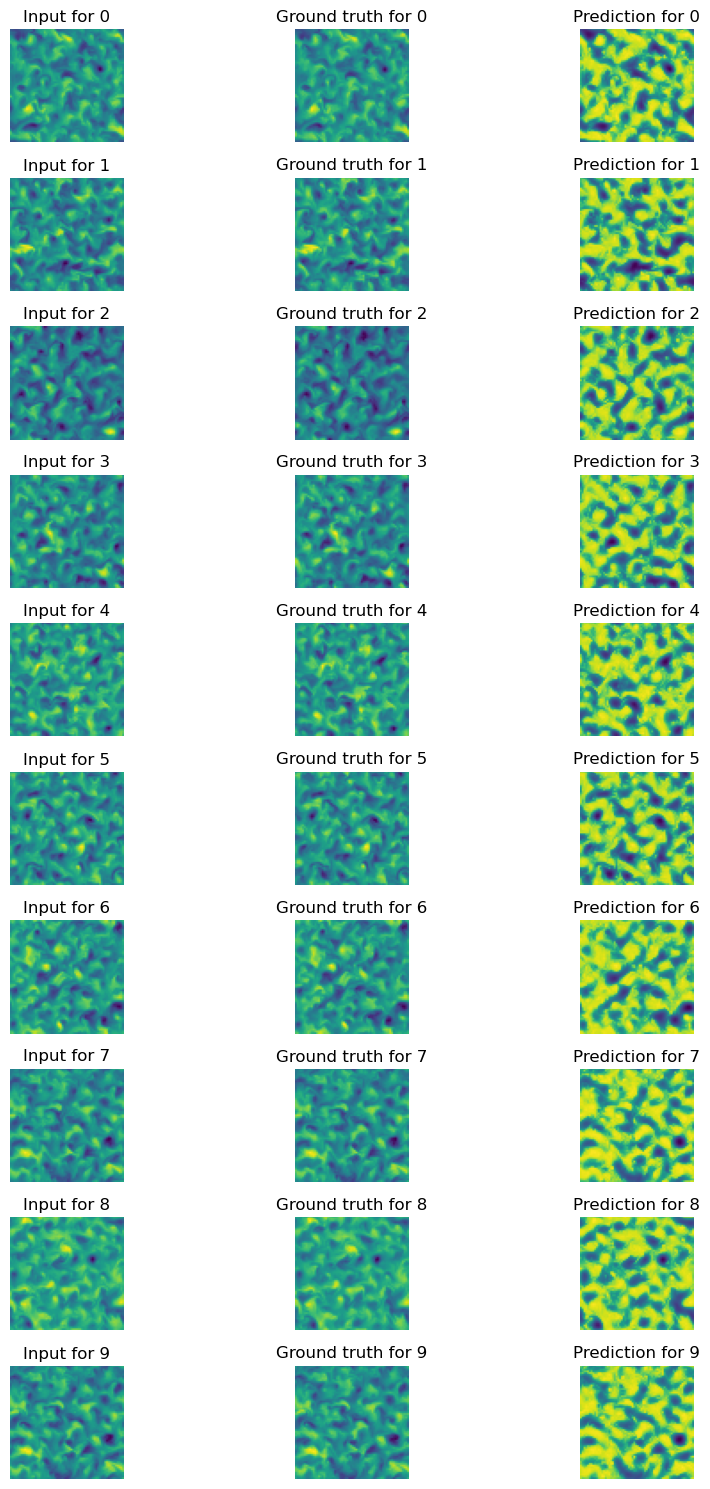

In [7]:
# Test the trained model
with torch.no_grad():
    plots = 10
    fig, ax = plt.subplots(plots,3, figsize=(10,15))

    for i, (input_file, target_file) in enumerate(test_files):
        if i >=plots:
            break
        data = load_h5_pair(input_file, target_file, 'cpu')
        x, y = data
        x = x.reshape(1, 1, 10, 3, 64,64) # B, C, T, V, X, Y
        y = y.reshape(1, 1, 10, 3, 64,64) # B, C, T, V, X, Y
        pred = model(x)
        print(pred.min(), pred.max(), pred.mean())
        
        x_image = x[0,0,0,0]
        y_image = y[0,0,0,0]
        pred_image = pred[0,0,0,0]
        ax[i,0].imshow(x_image)
        ax[i,0].set_title(f"Input for {i}")
        ax[i,0].axis('off')
        ax[i,1].imshow(y_image)
        ax[i,1].set_title(f"Ground truth for {i}")
        ax[i,1].axis('off')
        ax[i,2].imshow(pred_image)
        ax[i,2].set_title(f"Prediction for {i}")
        ax[i,2].axis('off')

    plt.tight_layout()
    plt.show()